In [369]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from kmodes.kprototypes import KPrototypes

In [370]:
df = pd.read_csv('anon_data.csv', dtype=str)
df

,CustomerId,SalesOrderNumber,SalesOrderLineNumber,ShipDate,Qty,Brand,ProductType,ProductSupplierID,Revenue,Profit,Freight cost,SalesTeamName
0,0100002803,0002913843,10,02/04/2021,2,Microsoft,Operating System Software,1000477.0,254.21378247534085,1.2710480691814492,0.0,Components North
1,0100003323,0002918083,50,02/04/2021,1,Microsoft,Utilities Software,1000477.0,191.68200133836768,6.179373262058722,0.0,Corporate North
2,0100016168,0002916878,20,02/04/2021,1,Unknown,IT Support Services,1000465.0,0.0,-8.011782597961698,0.0,Corporate North
3,0100001590,0002470475,10,02/04/2021,10,Lenovo,Notebook Computers,1000133.0,21362.97964441052,133.94413842837506,0.0,Corporate South
4,0100001590,0002544987,10,02/04/2021,5,Lenovo,Notebook Computers,1000133.0,4344.370601561705,27.63949729537495,0.0,Corporate South
...,...,...,...,...,...,...,...,...,...,...,...,...
488706,0100010912,60584191.0,10,10/03/2023,-1,Lightwave RF,Smart Home Lighting,1000592.0,-53.174831305353074,-4.746283538083776,0.0,SMB 1 North
488707,0100013325,60583918.0,10,10/03/2023,-1,Sandisk Professional,Desktop HDD,0001000043,-137.487216424425,-9.413256111997837,0.0,Components North
488708,0100014212,60584292.0,10,10/03/2023,-1,Epson,Ink Cartridges,1000056.0,-136.97144839673993,-11.899224843620617,0.0,Office Automation
488709,0100015609,60584541.0,10,10/03/2023,-1,Zanussi,Vacuum Cleaners,1002099.0,-50.589044895329856,10.0806430572465,0.0,Corporate North


### **PreProcessing**

##### To begin with we can sort our data into categorical, numerical and datetime categories, each of which will be processed separately.
##### **Categorical:** CustomerId, SalesOrderNumber, SalesOrderLineNumber, Brand, ProductType, ProductSupplierID, SalesTeamName
##### **Numerical:** Qty, Revenue, Profit, Freight cost
##### **DateTime:** ShipDate
##### <br>

##### As the data has been loaded as a string type, we can look at a description of the data to compare the total values and the unique values.

In [371]:
df.describe()[0:2].T

,count,unique
CustomerId,488711,3323
SalesOrderNumber,488711,377549
SalesOrderLineNumber,488711,105
ShipDate,488711,567
Qty,488711,860
Brand,488630,337
ProductType,488630,423
ProductSupplierID,486423,466
Revenue,488711,487715
Profit,488711,487923


##### Since all of the categorical values contain some set of repeated values, we can keep all of the data for modelling. However there is some discrepancy between the counts of Brand, ProductType and ProductSupplierID and the total index count, which applies missing values, which we will check next.

In [372]:
df.isna().sum()

CustomerId                 0
SalesOrderNumber           0
SalesOrderLineNumber       0
ShipDate                   0
Qty                        0
Brand                     81
ProductType               81
ProductSupplierID       2288
Revenue                    0
Profit                     0
Freight cost               0
SalesTeamName              0
dtype: int64

##### As expected, the three columns in question have missing values. As the percentage of missing values are 0.017%, 0.017% and 0.47% respectively, which is relatively very low, we can create a new 'unknown' category and fill the values with it.

In [373]:
df = df.fillna('N/A')
df.isna().sum()

CustomerId              0
SalesOrderNumber        0
SalesOrderLineNumber    0
ShipDate                0
Qty                     0
Brand                   0
ProductType             0
ProductSupplierID       0
Revenue                 0
Profit                  0
Freight cost            0
SalesTeamName           0
dtype: int64

##### Next we shall convert all the data types in the dataframe to represent determined categories, with Categorical variables being converted to strings, Numerical variables being converted to floats and DateTime Variables being converted to datetime objects.

In [374]:
df['Qty'] = df['Qty'].apply(lambda qty: qty.replace(',', '.'))

df = df.astype({'CustomerId': 'str',
                'SalesOrderNumber': 'str',
                'SalesOrderLineNumber': 'str',
                'Brand': 'str',
                'ProductType': 'str',
                'ProductSupplierID': 'str',
                'SalesTeamName': 'str',
                'Qty': 'float',
                'Revenue': 'float',
                'Profit': 'float',
                'Freight cost': 'float'})

df['ShipDate'] = df['ShipDate'].apply(lambda shipdate: datetime.strptime(shipdate, '%d/%m/%Y').date())

##### Finally we shall cut out data which has zero or negative quantities and negative freight costs as this represents anomalous data.

In [375]:
df = df[(df.Qty >= 0) & (df['Freight cost'] > 0)]
df.reset_index(inplace=True)
df

,index,CustomerId,SalesOrderNumber,SalesOrderLineNumber,ShipDate,Qty,Brand,ProductType,ProductSupplierID,Revenue,Profit,Freight cost,SalesTeamName
0,24,0100000985,0002918420,10,2021-04-03,2.0,Startech,USB Graphics Adapters,0001000171,64.574954,1.736422,0.13,Corporate North
1,25,0100000985,0002918420,20,2021-04-03,10.0,Startech,HDMI Cables,0001000171,37.337265,1.669353,0.18,Corporate North
2,26,0100000985,0002918420,30,2021-04-03,2.0,Startech,USB Cables,0001000171,69.921078,3.540645,0.27,Corporate North
3,27,0100000985,0002918420,40,2021-04-03,1.0,Startech,Transceiver & Media Converters,1000171.0,73.606653,2.659754,0.12,Corporate North
4,28,0100000985,0002918420,60,2021-04-03,11.0,Dell,Monitors,1000003.0,1248.125975,58.690666,16.14,Corporate North
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423037,488249,0100010479,1006583100.0,30,2023-03-09,2.0,Epson,Ink Cartridges,1000056.0,100.407113,9.711315,5.11,Office Automation
423038,488250,0100010479,1006583100.0,40,2023-03-09,2.0,Epson,Ink Cartridges,1000056.0,207.935562,22.125938,3.02,Office Automation
423039,488251,0100010479,1006583100.0,50,2023-03-09,2.0,Epson,Ink Cartridges,1000056.0,204.008019,23.369093,3.00,Office Automation
423040,488252,0100010479,1006583100.0,60,2023-03-09,2.0,Epson,Ink Cartridges,1000056.0,206.068191,19.244544,2.96,Office Automation


## **Questions**
##### **Question 1- How do the numerical variables correlate?**

##### To begin with we will look at a correlation matrix between each feature to find if there is any correlation.

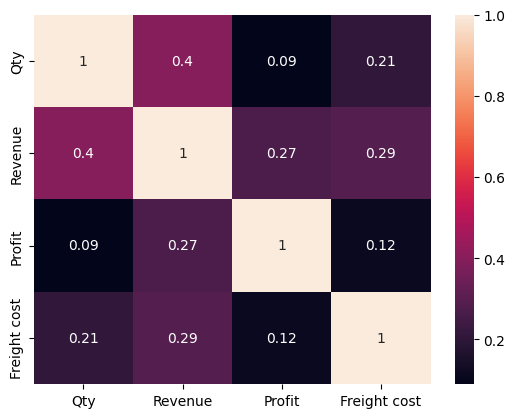

In [376]:
correlations = df[['Qty', 'Revenue', 'Profit', 'Freight cost']].corr(method='pearson')
sns.heatmap(correlations, annot=True);

##### Here we can see that the only notable correlation is between Qty and Revenue which we can investigate further

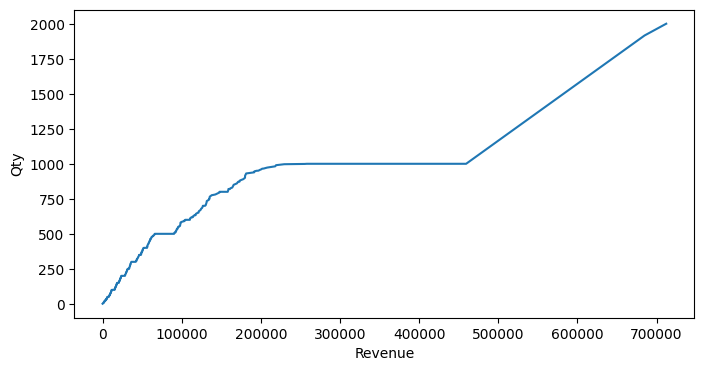

In [399]:
fig, ax = plt.subplots(figsize=(8, 4))
qty = sorted(df.loc[:, 'Qty'])
revenue = sorted(df.loc[:, 'Revenue'])

sns.lineplot(x=revenue, y=qty, ax=ax)
ax.set_xlabel('Revenue')
ax.set_ylabel('Qty');

##### Whilst this is not an explicitly linear relationship, we can clearly see correlation between the variables which may be useful in a predictive algorithm, in which case we could find out which variable motivates the weights more effectively.

##### **Question 2- What are the most lucrative brands?**

##### Firstly there are several ways to answer this question. We can look at total quantity sold, total revenue and total profit. Whilst profit is the obvious immediate indicator, both sales and revenue relate to market share and may be relevant to growth in the future.

In [383]:
df_ = df.copy()
df_.insert(0, 'Count', [1 for num in range(df.shape[0])])
table = pd.pivot_table(df_, index=['Brand'], values=['Profit', 'Revenue', 'Count'], aggfunc={'Profit': np.mean,
                                                                                             'Revenue': np.mean,
                                                                                             'Count': np.sum})

table = table.sort_values('Count', ascending=False)
table

,Count,Profit,Revenue
Brand,,,
Dell,79470,24.899354,949.407913
Lenovo,35737,47.221272,2290.502180
Startech,34814,4.935542,102.797731
Epson,30601,21.421153,340.697257
Samsung,19987,36.311813,726.384619
...,...,...,...
Fortinet,1,0.192109,0.265613
Numskull,1,0.185376,0.240612
Signagelive,1,4359.461278,36755.831703


##### Next we will look at the count percentiles of each brand so we can trim the results to a more managable number and avoid any anomalies

In [384]:
pd.DataFrame({k: np.percentile(table.Count, q=k) for k in np.arange(start=0, stop=100, step=5)}, index=['Value']).T

,Value
0,1.0
5,1.0
10,1.0
15,2.0
20,3.0
25,5.0
30,7.8
35,13.0
40,16.4
45,23.7


##### Here we can see that there are a large number of brands with relatively few sales within the data, thus we will trim the data to the 95th percentile which averages just under 7000 sales made, and look at a bar plot of the counts.

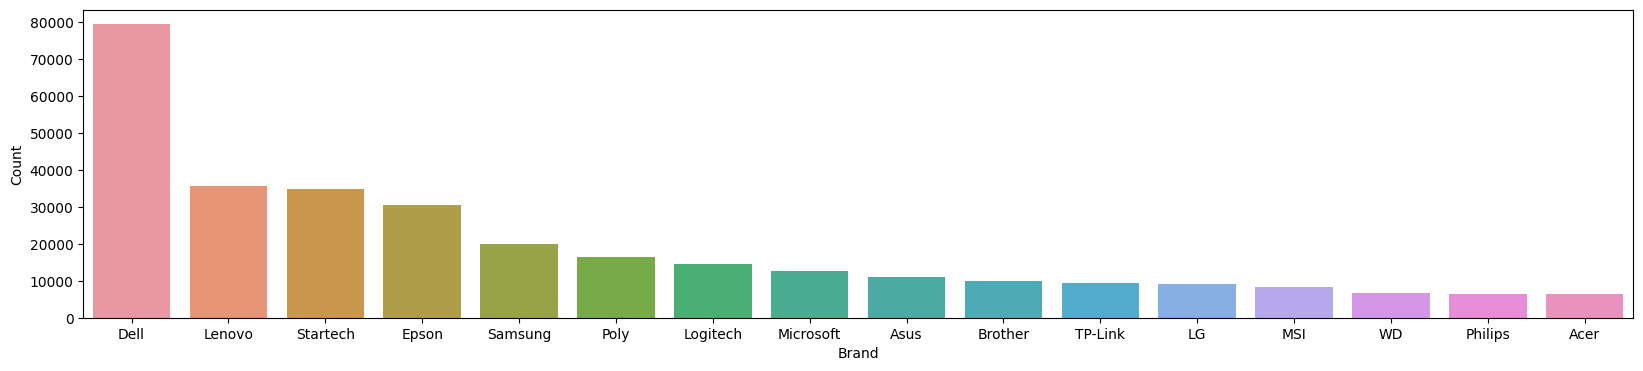

In [385]:
table = table[table.Count >= np.percentile(table.Count, q=95)]

fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(x=table.index, y=table.Count);

##### Clearly Dell, Lenovo, Startech and Epson dominate the total sales, however we may find some high profit/revenue brands further in the analysis. Next we will look at the total profit for each brand along with the profit/revenue ratio to determine the most profitable brands and how that scales with revenue.

In [386]:
count = table.loc[:, 'Count']
profit = table.loc[:, 'Profit']
revenue = table.loc[:, 'Revenue']

table.insert(table.shape[1], 'Total Profit', [count[num] * profit[num] for num in range(table.shape[0])])
table.insert(table.shape[1], 'Profit / Revenue', [f'{np.around(100 * profit[num] / revenue[num], 2)}%' for num in range(table.shape[0])])
table

,Count,Profit,Revenue,Total Profit,Profit / Revenue
Brand,,,,,
Dell,79470,24.899354,949.407913,1.978752e+06,2.62%
Lenovo,35737,47.221272,2290.502180,1.687547e+06,2.06%
Startech,34814,4.935542,102.797731,1.718260e+05,4.8%
Epson,30601,21.421153,340.697257,6.555087e+05,6.29%
Samsung,19987,36.311813,726.384619,7.257642e+05,5.0%
Poly,16327,29.173130,593.124954,4.763097e+05,4.92%
Logitech,14554,12.014211,274.287746,1.748548e+05,4.38%
Microsoft,12744,6.885285,181.448692,8.774608e+04,3.79%
Asus,10986,53.297788,1730.195244,5.855295e+05,3.08%


##### From this we can deduce that Dell and Lenovo are clearly the most profitable companies. In terms of profit percentage, Epson is clearly the most lucrative per individual item sold, however suffers from lower sales. Samsung, LG, Philips and Brother also have high profit margins, and thus all these companies could be worth marketing in the future.

##### **Question 3- Do customers show brand loyalty?**

##### The CustomerId is assumed to belong to an individual customer and therefore we can group the data in terms of each customer and brand with regards to quantity, to represent total number of products bought.
##### We can begin by looking at the subset of customers that bought the most items to deduce a consistent sample.

In [401]:
df_ = df.copy()

table = pd.pivot_table(df_, index=['CustomerId'], values=['Qty'], aggfunc={'Qty': np.sum})
table = table.sort_values('Qty', ascending=False)
table

,Qty
CustomerId,
0100007970,175795.000
0100004474,152379.000
0100004472,145805.670
0100001590,140719.971
0100001570,90669.061
...,...
0100017576,1.000
0100009030,1.000
0100009039,1.000


##### Next we will aggregate the purchased quantities of the top three brands relative to each customer, and calculate the quantities as a percentage of the customers total quantity to determine how much the average customer is shopping at their top brands.

In [402]:
table_2 = pd.pivot_table(df_, index=['CustomerId'], columns=['Brand'], values=['Qty'], aggfunc={'Qty': np.sum})
output = {customerid: [] for customerid in df_.CustomerId.unique()}

for customerid in table.index:
    quant_per_brand = sorted(table_2.loc[customerid, :].dropna(), reverse=True)
    total_quant = table.loc[customerid, :].Qty
    
    try:
        output[customerid].append(np.around(100 * quant_per_brand[0] / total_quant, 2))
    except IndexError:
        output[customerid].append(np.nan)
        
    try:
        output[customerid].append(np.around(100 * quant_per_brand[1] / total_quant, 2))
    except IndexError:
        output[customerid].append(np.nan)
        
    try:
        output[customerid].append(np.around(100 * quant_per_brand[2] / total_quant, 2))
    except IndexError:
        output[customerid].append(np.nan)

results = pd.DataFrame(data=output, index=['1st Brand Quantity Share', '2nd Brand Quantity Share', '3rd Brand Quantity Share']).T
results.head()

,1st Brand Quantity Share,2nd Brand Quantity Share,3rd Brand Quantity Share
0100000985,32.77,16.37,13.82
0100001046,29.17,27.26,16.84
0100002801,38.89,32.64,10.42
0100002803,26.43,16.00,12.91
0100004865,66.67,33.33,NaN


##### Here we can see a sample of 5 customers, with their top three most shopped at brands expressed as a percentage of their total purchasing quantities. Next we can find the average quantity percentage at these top three brands to determine if each customers are generally brand loyal or not.

In [403]:
results.describe()

,1st Brand Quantity Share,2nd Brand Quantity Share,3rd Brand Quantity Share
count,3163.000000,2224.000000,1750.000000
mean,69.660364,20.383763,11.013183
std,27.351808,11.514217,6.450593
min,6.090000,0.030000,0.020000
25%,46.200000,11.985000,6.455000
50%,70.000000,19.380000,10.380000
75%,100.000000,27.287500,14.710000
max,100.000000,50.000000,33.330000


##### Looking at the mean of this table, the average customer purchases nearly 70% of their orders from their top most visited brand, whilst this drops off heavily at their second and third most visited brand averaging 20% and 11% respectively. Whilst the standard deviation of this calculation is relatively high, it at least implies a strong loyalty for most customers towards their top most visited brand, and thus could provide useful input for marketing purposes.

## Cluster Modelling

##### To cluster the data, we will use K-means clustering on the numerical data provided. This is chosen as the data is relatively centralised with few outliers, the dataset is large which will make incorporating the large amount of categorical data very time consuming to model, and defining the amount of clusters will allow us to directly categorise customers around their relative spending habits with a chosen level of granularity.

##### Therefore we will consider the Qty and Revenue variables for this model. Freight cost and profit will be excluded as both of these variables reflect business metrics rather than customer metrics and would be unavailable information to the customer, thus not influencing their buying habits.

##### First we shall scale the data for normalisation purposes, then visualise the three variables to get an intuition on the number of clusters.

In [391]:
model_data=scaler.fit_transform(df[['Qty', 'Revenue']])

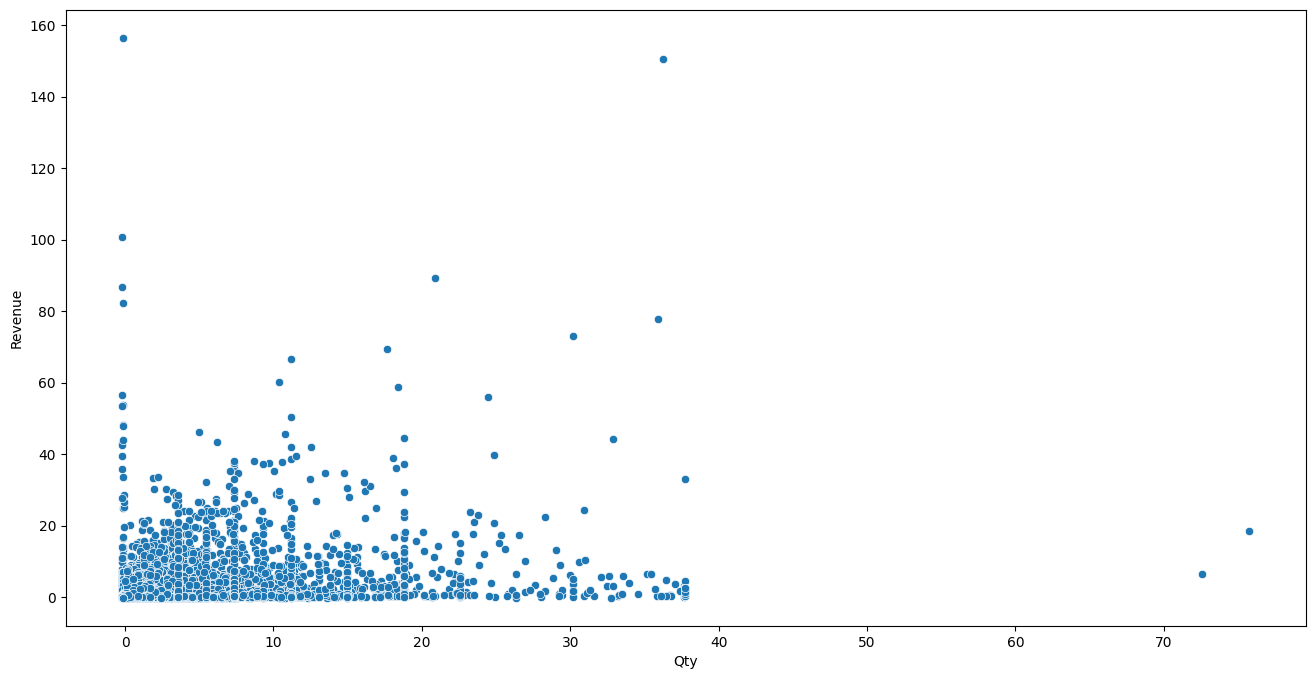

In [392]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(x=model_data[:, 0], y=model_data[:, 1], ax=ax)
ax.set_xlabel('Qty')
ax.set_ylabel('Revenue');

##### Upon visual inspection we can roughly categroise customers into:
##### - Low quantity, low spend
##### - High quantity, low spend
##### - High quantity, high spend
##### - High quantity, high spend
##### - Outliers
##### For a more systematic approach in addressing the optimal cluster number we will use the elbow method.

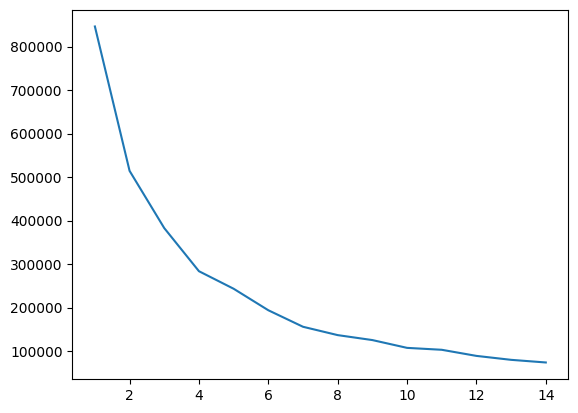

In [393]:
distortions = {k: 0 for k in range(1, 15)}

for k in distortions.keys():
    kmeans = KMeans(n_init='auto', n_clusters=k)
    kmeans.fit(model_data)
    distortions[k] = kmeans.inertia_

sns.lineplot(x=distortions.keys(), y=distortions.values());

##### Here we can judge the optimal number of clusters from around 4 as that fits the reduction in the curve. This is also very close to our earlier assumption based on visual inspection of 5 clusters.

In [394]:
kmeans = KMeans(n_init='auto', n_clusters=4)
kmeans.fit(model_data)
clusters = kmeans.cluster_centers_

##### Here we can see the cluster centers visualised, along with how each data point is classified

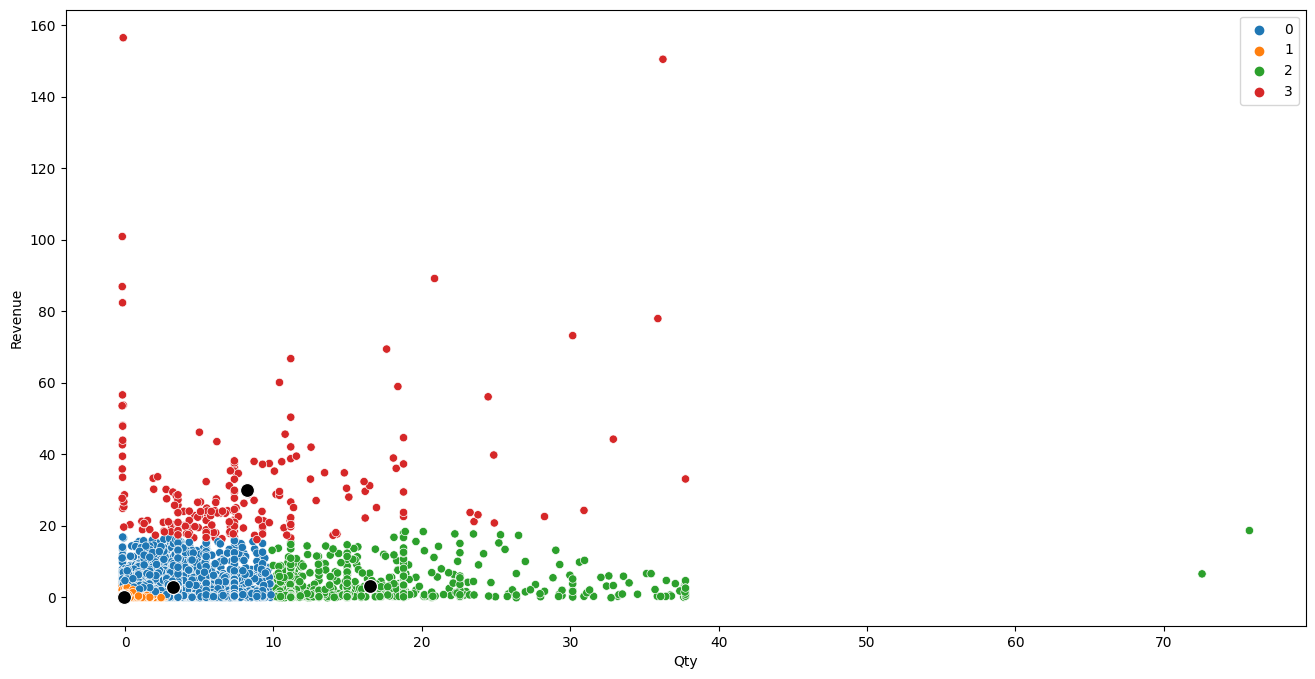

In [395]:
palette = sns.color_palette('tab10')
sns.set_palette('tab10')

fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(x=model_data[:, 0], y=model_data[:, 1], ax=ax, hue=kmeans.labels_, palette=sns.color_palette('tab10', n_colors=4))
sns.scatterplot(x=clusters[:, 0], y=clusters[:, 1], ax=ax, s=100, c='black', markers=['X'])
ax.set_xlabel('Qty')
ax.set_ylabel('Revenue');

##### Looking at this, the clusters clearly reflect the high price/high quantity split, along with medium and low price/quantity items. However, further clusters may be useful in identifying the scale of high price and quantity items as there is clearly sparsity as the price and quantity increase. To account for this we can try 6 clusters.

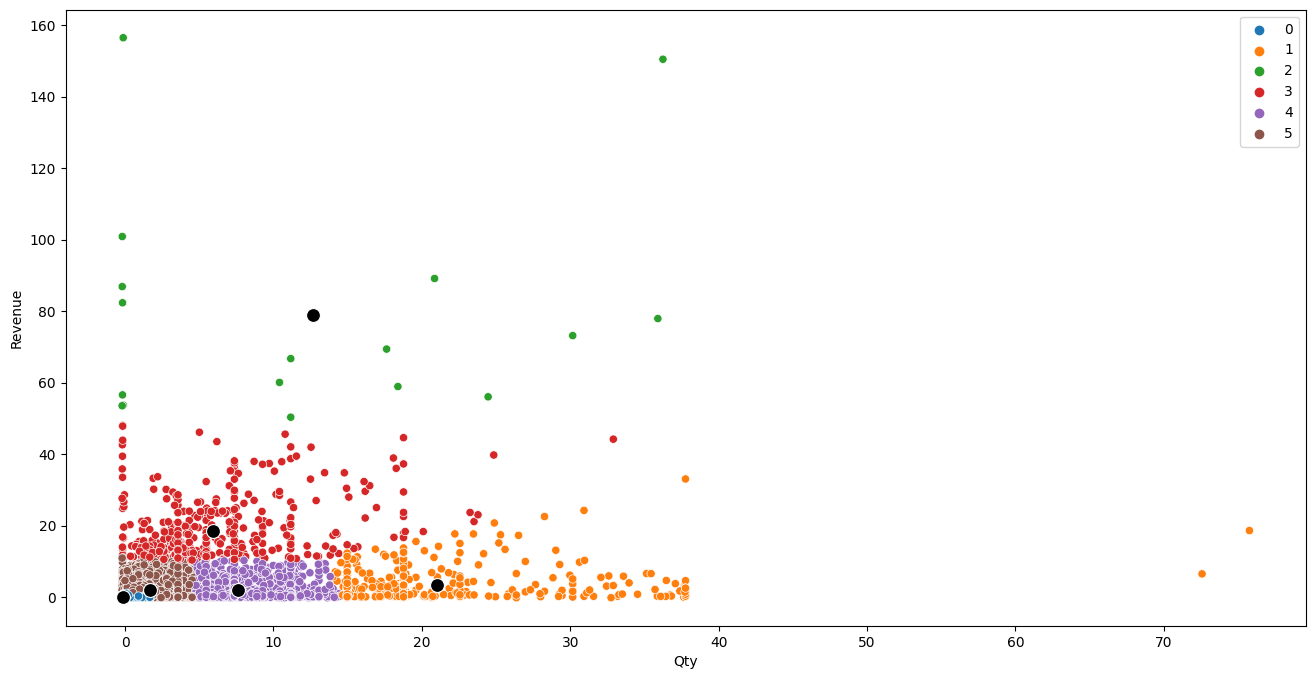

In [396]:
kmeans = KMeans(n_init='auto', n_clusters=6)
kmeans.fit(model_data)
clusters = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(x=model_data[:, 0], y=model_data[:, 1], ax=ax, hue=kmeans.labels_, palette=sns.color_palette('tab10', n_colors=6))
sns.scatterplot(x=clusters[:, 0], y=clusters[:, 1], ax=ax, s=100, c='black', markers=['X'])
ax.set_xlabel('Qty')
ax.set_ylabel('Revenue');

##### At 6 clusters we can see a comfortable division of the data between:
##### - Customer buys near zero cost/quantity items
##### - Customer buys high price/low quantity items
##### - Customer buys very high price items
##### - Customer buys high quantity/low price items
##### - Customer buys medium price/medium quantity items
##### - Customer buys high quantity/low price items
##### We could go further and sub divide the data to achieve greater granularity, however we may risk overcomplicating the categories, thus I'm happy to settle on 6 clusters to represent customers behaviour in regards to buying items with respect to cost and quantity.